<center><h1>Deep learing project no.1</h1></center>

<h3>Authors:</h3>
<p>Marek Szydłowski 136633 <br/>
Wotjek Tomczak 145467<p>

In [1]:
%matplotlib inline
import os
import fnmatch

from pathlib import Path

from IPython.display import display

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import gdown

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, precision_recall_fscore_support
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]

2021-11-17 21:50:17.408858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 21:50:17.408873: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<center><h1>Part 1.</h1></center>

<center><h1>Downloading the data</h1></center>

In [2]:
DATA_DIR = "data/"
DATA_PATH = DATA_DIR + "101_ObjectCategories/"
DATA_TAR = DATA_DIR + "101_ObjectCategories.tar.gz"
MODELS_PATH = "models/"

BACKGROUND_GOOGLE = DATA_PATH + "BACKGROUND_Google"


In [3]:
data_check = Path(DATA_PATH)
tar_check = Path(DATA_TAR)

!mkdir -p $DATA_DIR

if not data_check.exists() and not tar_check.exists():
    # No data exists
    gdown.download("https://drive.google.com/uc?id=194fJtjdnJUsH6qDdOmMAgnbBcHcVWwgT", DATA_DIR, False)

if tar_check.exists():
    # Extract and remove tar.gz file
    !tar -xf $DATA_TAR --directory="data"
    !rm -r $BACKGROUND_GOOGLE
    !rm $DATA_TAR


<center><h1>Data preprocessing</h1></center>

In [4]:
# cheking size of classes in our database of choice

file_counter = []

for data_dir in Path(DATA_PATH).iterdir():
    file_counter.append(
        [
            len(fnmatch.filter(os.listdir(data_dir), "*.jpg")),
            str(data_dir).split("/")[-1],
        ]
    )

results = pd.DataFrame(
    sorted(file_counter, key=lambda x: x[0], reverse=True),
    columns=["FILE_COUNT", "CLASS_NAME"],
)

results


,FILE_COUNT,CLASS_NAME
0,800,airplanes
1,798,Motorbikes
2,435,Faces
3,435,Faces_easy
4,239,watch
...,...,...
96,34,platypus
97,34,wild_cat
98,33,binocular
99,32,metronome


In [5]:
classes = results[results["FILE_COUNT"] > 80]["CLASS_NAME"].values
max_len = np.min(results[results["FILE_COUNT"] > 80]["FILE_COUNT"])


In [6]:
classes


array(['airplanes', 'Motorbikes', 'Faces', 'Faces_easy', 'watch',
       'Leopards', 'bonsai', 'car_side', 'ketch', 'chandelier',
       'hawksbill', 'grand_piano', 'brain', 'butterfly', 'helicopter',
       'menorah', 'kangaroo', 'starfish', 'trilobite', 'buddha', 'ewer',
       'sunflower', 'scorpion', 'revolver', 'laptop'], dtype=object)

In [7]:
images = {}
for data_dir in Path(DATA_PATH).iterdir():
    if data_dir.name in classes:
        current_len = 0
        for f in data_dir.iterdir():
            if current_len == max_len:
                break

            if not f.is_file():
                continue

            current_len += 1

            if data_dir.name not in images:
                images[data_dir.name] = 1
            else:
                images[data_dir.name] += 1

df = (
    pd.DataFrame.from_dict(images, "index")
    .reset_index()
    .rename({0: "length", "index": "name"}, axis=1)
)


In [8]:
df


,name,length
0,Faces,81
1,Faces_easy,81
2,Leopards,81
3,Motorbikes,81
4,airplanes,81
5,bonsai,81
6,brain,81
7,buddha,81
8,butterfly,81
9,car_side,81


In [9]:
dataset = []
labels = []
filenames = []

for row in df.itertuples():
    dirname = row.name
    max_len = row.length

    current_len = 0
    for filename in os.listdir(DATA_PATH + dirname):
        if current_len == max_len:
            break

        if ".jpg" not in filename:
            continue

        current_len += 1

        img = cv2.imread(DATA_PATH + dirname + "/" + filename)
        resized = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

        filenames.append(dirname + "/" + filename)
        dataset.append(resized)
        labels.append(dirname)

dataset = np.array(dataset)


In [10]:
dataset.shape


(2025, 64, 64, 3)

In [11]:
bgr_mean = np.mean(dataset, axis=(0, 1, 2))
bgr_std = np.std(dataset, axis=(0, 1, 2))
bgr_mean, bgr_std


(array([123.95332875, 132.96645978, 137.9144864 ]),
 array([80.14290487, 76.34923509, 78.34238172]))

In [12]:
std_data = (dataset - bgr_mean) / bgr_std
std_data.shape


(2025, 64, 64, 3)

Image before standardization


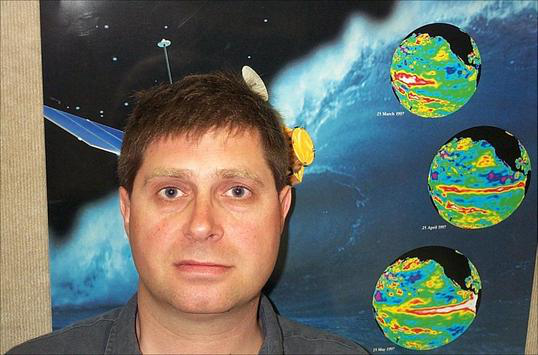

In [13]:
print("Image before standardization")
with Image.open(DATA_PATH + filenames[0]) as img:
    display(img)


In [14]:
# # DO NOT CLOSE IMAGE WITH "X" ICON, JUST WAIT
# # Uncoment to run


# cv2.imshow('tmp', std_data[0])
# cv2.waitKey(7000)

# cv2.destroyAllWindows()


<center><h1>Splitting data into Train and Test</h1></center>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    std_data, list(zip(labels, filenames)), stratify=labels, test_size=0.3, random_state=23
)

y_train, y_test = np.array(y_train), np.array(y_test)

y_train, train_fnames = y_train[:, 0], y_train[:, 1]
y_test, test_fnames = y_test[:, 0], y_test[:, 1]


In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1417, 64, 64, 3), (608, 64, 64, 3), (1417,), (608,))

In [17]:
def oneHotterEncoder(target):
    _target = target.reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown="ignore")
    new_target = encoder.fit(_target)
    return new_target.categories_, new_target.transform(_target).toarray()


In [18]:
classes_train, y_train_enc = oneHotterEncoder(y_train)
classes_test, y_test_enc = oneHotterEncoder(y_test)

(classes_train,) = classes_train
(classes_test,) = classes_test


<center><h1>Model definition and training</h1></center>

In [19]:
def create_and_solve_model(
    isDropout=True,
    drop_1=0.75,
    drop_2=0.65,
    activation="relu",
    isBatchNormalization=True,
    pooling=layers.MaxPool2D,
    no_conv_layers=2,
    batch_size=32,
    verbose=False,
):
    """Helper function for all experiments with tasks."""

    model = models.Sequential()

    model.add(
        layers.Conv2D(
            32,
            (3, 3),
            activation=activation,
            padding="same",
            input_shape=X_train[0].shape,
        )
    )
    model.add(pooling((2, 2)))

    for i in range(no_conv_layers):
        model.add(layers.Conv2D(64, (3, 3), activation=activation, padding="same"))
        if i != no_conv_layers - 1:
            model.add(pooling((2, 2)))

    if isBatchNormalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    if isDropout:
        model.add(layers.Dropout(drop_1))

    model.add(layers.Dense(64))

    if isDropout:
        model.add(layers.Dropout(drop_2))

    model.add(layers.Dense(64))
    model.add(layers.Dense(len(classes), activation="softmax"))

    if verbose:
        print(f"Number of classes: {len(classes)}")
        model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    history = model.fit(
        X_train,
        y_train_enc,
        batch_size=batch_size,
        epochs=250,
        validation_data=(X_test, y_test_enc),
        callbacks=[early_stopping],
        use_multiprocessing=True,
        verbose=verbose,
    )

    params = {
        "isDropout": isDropout,
        "drop_1": drop_1,
        "drop_2": drop_2,
        "activation": activation,
        "isBatchNormalization": isBatchNormalization,
        "pooling": pooling,
        "no_conv_layers": no_conv_layers,
        "batch_size": batch_size,
    }

    return model, history, params


In [20]:
def plot_model_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(history.history["accuracy"], label="accuracy")
    ax1.plot(history.history["val_accuracy"], label="val_accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title('Accuracy')
    ax1.set_ylim([0.5, 1])
    ax1.legend(loc="lower right")
    
    ax2.plot(history.history["loss"], label="loss")
    ax2.plot(history.history["val_loss"], label="val_loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title('Loss')
    ax2.legend(loc="lower right")
    
    fig.suptitle('Model accuracy and loss')
    plt.show()

In [21]:
def display_confusion_matrix(model):
    y_pred = np.argmax(model.predict(X_test), axis=1)

    tmp = []
    for item in y_test:
        tmp.append(np.where(classes_test == item))

    y_true = np.array(tmp).reshape(y_pred.shape)

    prec, rec, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    for ind in range(len(prec)):
        print(
            f"Class {ind}:\tPrecision: {round(prec[ind], 3):<10}"
            f"Recall: {round(rec[ind], 3):<10}"
            f"F-score: {round(fscore[ind], 3):<10}"
        )

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    _ = disp.plot()



In [22]:
def print_update_test_acc(model, best_model=None):
    """Returns True if current acc is better, False otherwise"""
    _, test_acc = model.evaluate(X_test, y_test_enc, verbose=2)
    print(f"Test accuracy: {round(test_acc * 100, 3)}%\n")

    if best_model is None:
        return False

    _, best_acc = best_model.evaluate(X_test, y_test_enc, verbose=2)
    return test_acc * 1.05 > best_acc


In [23]:
def display_example_images(model):
    predict_val = model.predict(X_test)
    predict_class = np.argmax(predict_val, axis=1)
    
    tmp = classes_test[predict_class] == y_test
    
    correctly_classified = np.where(tmp == True)[0][0]
    incorrectly_classified = np.where(tmp == False)[0][0]

    for val_idx, phrase in zip([correctly_classified, incorrectly_classified], ['correctly', 'incorrectly']):
        if val_idx is not None:
            print(f'Photo {test_fnames[val_idx]} {phrase} classified as {classes_test[predict_class[val_idx]]}')
            with Image.open(DATA_PATH + test_fnames[val_idx]) as img:
                display(img)
            for class_no, class_prob in enumerate(predict_val[val_idx]):
                print(f'{f"Class {class_no} probability:":<24}{round(class_prob * 100, 3)}%')
        else:
            print(f'No {phrase} classified photo found')
        print('\n\n')

In [24]:
model, history, params = create_and_solve_model(verbose=True)

2021-11-17 21:50:35.031712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 21:50:35.032153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marek-szyd/Programs/anaconda3/envs/dl/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-17 21:50:35.032223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/marek-szyd/Programs/anaconda3/envs/dl/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-17 21:50:35.032281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dyn

Number of classes: 25
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization (BatchN  (Non

Photo brain/image_0006.jpg correctly classified as brain


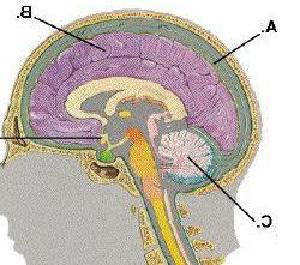

Class 0 probability:    2.401%
Class 1 probability:    0.653%
Class 2 probability:    0.328%
Class 3 probability:    0.114%
Class 4 probability:    0.227%
Class 5 probability:    1.637%
Class 6 probability:    35.45%
Class 7 probability:    0.128%
Class 8 probability:    3.44%
Class 9 probability:    0.297%
Class 10 probability:   8.891%
Class 11 probability:   1.194%
Class 12 probability:   14.967%
Class 13 probability:   6.326%
Class 14 probability:   0.627%
Class 15 probability:   8.473%
Class 16 probability:   0.176%
Class 17 probability:   0.152%
Class 18 probability:   0.631%
Class 19 probability:   0.187%
Class 20 probability:   7.714%
Class 21 probability:   3.108%
Class 22 probability:   0.207%
Class 23 probability:   0.642%
Class 24 probability:   2.028%



Photo revolver/image_0052.jpg incorrectly classified as grand_piano


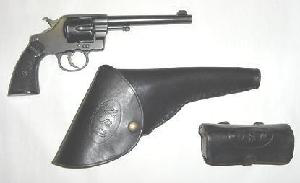

Class 0 probability:    1.986%
Class 1 probability:    0.659%
Class 2 probability:    1.49%
Class 3 probability:    0.292%
Class 4 probability:    0.299%
Class 5 probability:    0.988%
Class 6 probability:    0.017%
Class 7 probability:    0.296%
Class 8 probability:    0.152%
Class 9 probability:    1.963%
Class 10 probability:   0.048%
Class 11 probability:   0.204%
Class 12 probability:   23.357%
Class 13 probability:   16.208%
Class 14 probability:   6.079%
Class 15 probability:   6.751%
Class 16 probability:   0.02%
Class 17 probability:   0.754%
Class 18 probability:   0.001%
Class 19 probability:   11.163%
Class 20 probability:   2.28%
Class 21 probability:   23.163%
Class 22 probability:   0.449%
Class 23 probability:   1.217%
Class 24 probability:   0.163%





In [25]:
display_example_images(model)

19/19 - 0s - loss: 0.8902 - accuracy: 0.7681 - 192ms/epoch - 10ms/step
Test accuracy: 76.809%

Class 0:	Precision: 0.793     Recall: 0.958     F-score: 0.868     
Class 1:	Precision: 1.0       Recall: 1.0       F-score: 1.0       
Class 2:	Precision: 0.958     Recall: 0.958     F-score: 0.958     
Class 3:	Precision: 0.889     Recall: 1.0       F-score: 0.941     
Class 4:	Precision: 1.0       Recall: 0.875     F-score: 0.933     
Class 5:	Precision: 0.488     Recall: 0.833     F-score: 0.615     
Class 6:	Precision: 0.75      Recall: 0.72      F-score: 0.735     
Class 7:	Precision: 0.708     Recall: 0.68      F-score: 0.694     
Class 8:	Precision: 0.727     Recall: 0.32      F-score: 0.444     
Class 9:	Precision: 0.893     Recall: 1.0       F-score: 0.943     
Class 10:	Precision: 0.824     Recall: 0.583     F-score: 0.683     
Class 11:	Precision: 0.667     Recall: 0.75      F-score: 0.706     
Class 12:	Precision: 0.657     Recall: 0.92      F-score: 0.767     
Class 13:	Precisio

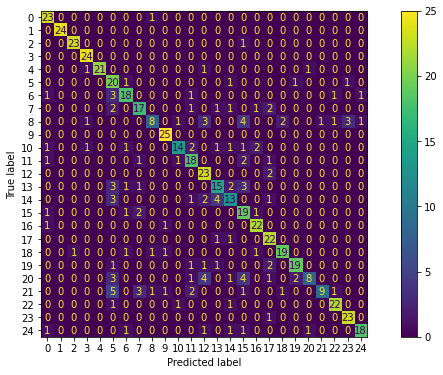

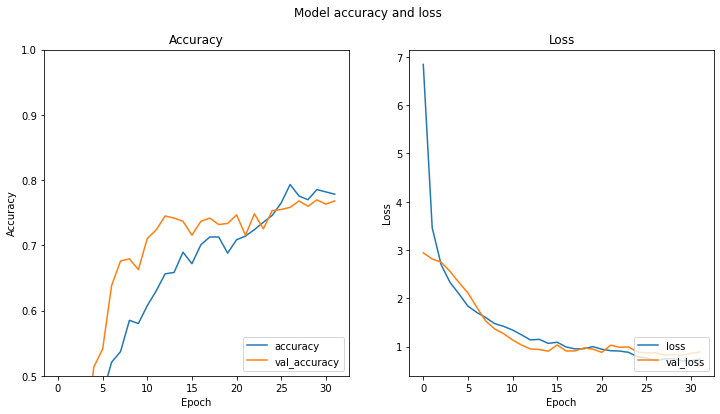

In [26]:
print_update_test_acc(model)
display_confusion_matrix(model)
plot_model_accuracy(history)

<center><h1>Saving model</h1></center>

In [27]:
def save_model(model, fname="model"):
    model.save(MODELS_PATH + fname)


def load_model(fname="model"):
    return tf.keras.models.load_model(MODELS_PATH + fname)


In [28]:
!mkdir -p $MODELS_PATH 

model.save(MODELS_PATH + "model")

2021-11-17 21:51:49.623263: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model/assets


In [29]:
model_loaded = load_model()


In [30]:
# Predictions on loaded model
predicted = np.argmax(model_loaded.predict(X_test), axis=1)
print(f'Prediction on loaded model: {round((np.count_nonzero(y_test == classes_test[predicted]) / y_test.size) * 100, 3)}')

Prediction on loaded model: 76.809


In [31]:
model_loaded.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       2

<center><h1>Summary</h1></center>

- What results have you achieved?

Validation accuracy is pretty high. Running the trainign of the model couple of times gave us differing results - from as low as 79% to as high as 86% so we can say that on average it has above 80% of an accuracy.

- Is the underfitting or overfitting of the model visible? If so, what are your suggestions for solving this problem?

For this specific model we don't think there is any under or overfitting. We can see though that if we were to train it a bit longer (if we did not use early stopping) the model would overfit. Signs of it can be seen by looking at charts of accuract and loss. At the end val_accuracy (on validation set) seems like it starts to go down as well as its loss while accuracy and loss on training set is going up.

- Which class(es) the model had a problem with? Which it did best with? Which pair of classes were most often confused with each other? Can you guess why?

Our model has problem with classes 10 and 15. Recall for these classes has value of 0.5 which is pretty low - meaning that only half of the examples are classified correctly.

- What improvement opportunities do you see?

We think that the data is a key problem in here and not a model architecture. Some of the training photos are of a poor quality.


<center><h1>Part 2.</h1></center>

In [32]:
# Initialize best model to our first model
best_model = model
best_model_params = params

<center><h3>Task 3.</h3></center>

No dropouts:
19/19 - 0s - loss: 1.0998 - accuracy: 0.7072 - 152ms/epoch - 8ms/step
Test accuracy: 70.724%

19/19 - 0s - loss: 0.8902 - accuracy: 0.7681 - 161ms/epoch - 8ms/step


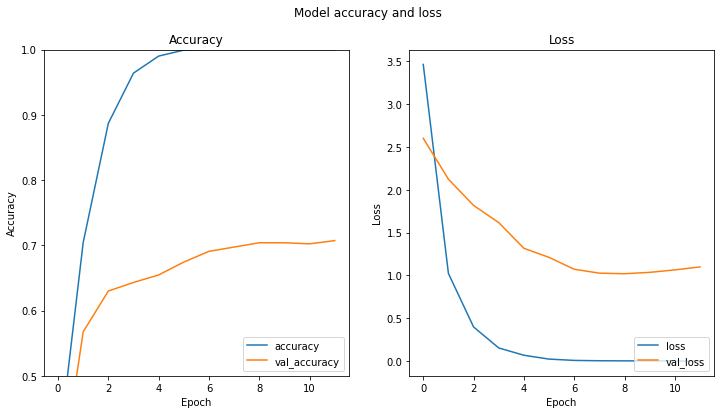



Model with dropout rates: 0.1
19/19 - 0s - loss: 1.2056 - accuracy: 0.7270 - 162ms/epoch - 9ms/step
Test accuracy: 72.697%

19/19 - 0s - loss: 0.8902 - accuracy: 0.7681 - 166ms/epoch - 9ms/step


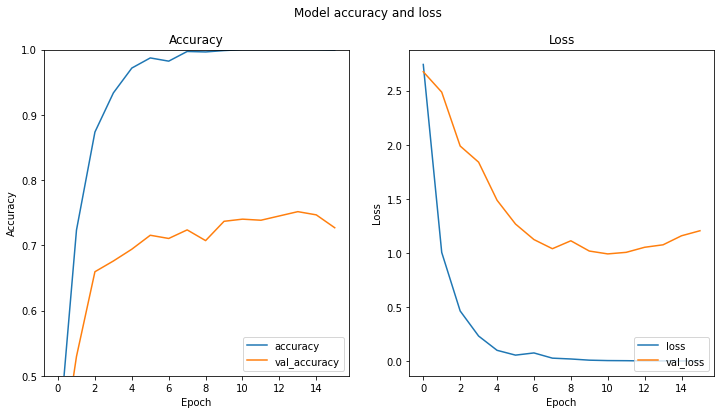



Model with dropout rates: 0.4
19/19 - 0s - loss: 1.6187 - accuracy: 0.6908 - 156ms/epoch - 8ms/step
Test accuracy: 69.079%

19/19 - 0s - loss: 0.8902 - accuracy: 0.7681 - 155ms/epoch - 8ms/step


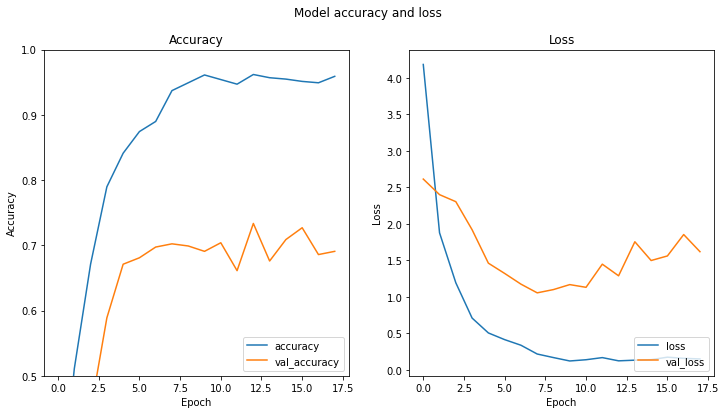



Model with dropout rates: 0.8
19/19 - 0s - loss: 0.9937 - accuracy: 0.7500 - 152ms/epoch - 8ms/step
Test accuracy: 75.0%

19/19 - 0s - loss: 0.8902 - accuracy: 0.7681 - 177ms/epoch - 9ms/step


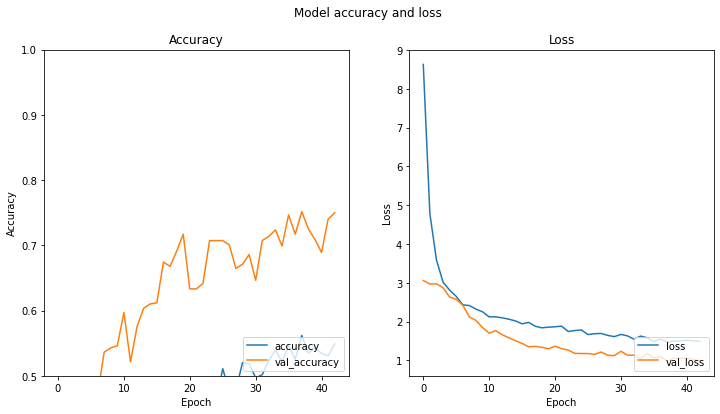

In [33]:


model_no_drop, history_no_drop, params_no_drop = create_and_solve_model(isDropout=False)

print("No dropouts:")
res = print_update_test_acc(model_no_drop, best_model)
if res:
    best_model = model_no_drop
    best_model_params = params_no_drop

plot_model_accuracy(history_no_drop)
print("\n")

for drop in [0.1, 0.4, 0.8]:
    par = {**best_model_params, **{"drop_1": drop, "drop_2": drop}}

    model_drop, history_drop, params_drop = create_and_solve_model(**par)

    print(f"Model with dropout rates: {drop}")
    res = print_update_test_acc(model_drop, best_model)
    if res:
        best_model = model_drop
        best_model_params = params_drop
    plot_model_accuracy(history_drop)
    print("\n")


<center><h3>Task 5.</h3></center>

With batch normalization:
19/19 - 0s - loss: 0.8902 - accuracy: 0.7681 - 159ms/epoch - 8ms/step
Test accuracy: 76.809%



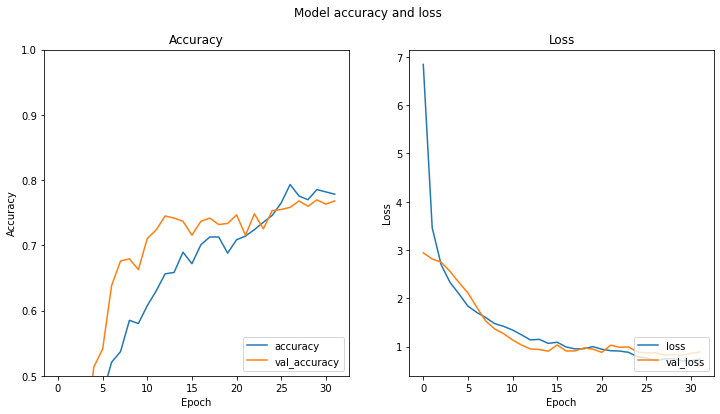



No batch normalization:
19/19 - 0s - loss: 0.8903 - accuracy: 0.7549 - 178ms/epoch - 9ms/step
Test accuracy: 75.493%

19/19 - 0s - loss: 0.9937 - accuracy: 0.7500 - 173ms/epoch - 9ms/step


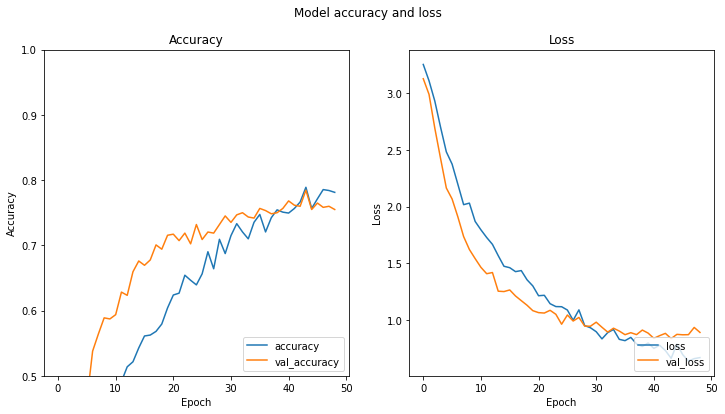

In [34]:
par = {**best_model_params, **{"isBatchNormalization": False}}

model_no_batch, history_no_batch, params_no_batch = create_and_solve_model(**par)

print("With batch normalization:")
print_update_test_acc(model)
plot_model_accuracy(history)
print("\n")

print("No batch normalization:")
res = print_update_test_acc(model_no_batch, best_model)
if res:
    best_model = model_no_batch
    best_model_params = params_no_batch
plot_model_accuracy(history_no_batch)
print("\n")


<center><h3>Task 7.</h3></center>

With ReLU activation:
19/19 - 0s - loss: 0.8902 - accuracy: 0.7681 - 173ms/epoch - 9ms/step
Test accuracy: 76.809%

19/19 - 0s - loss: 0.8903 - accuracy: 0.7549 - 152ms/epoch - 8ms/step


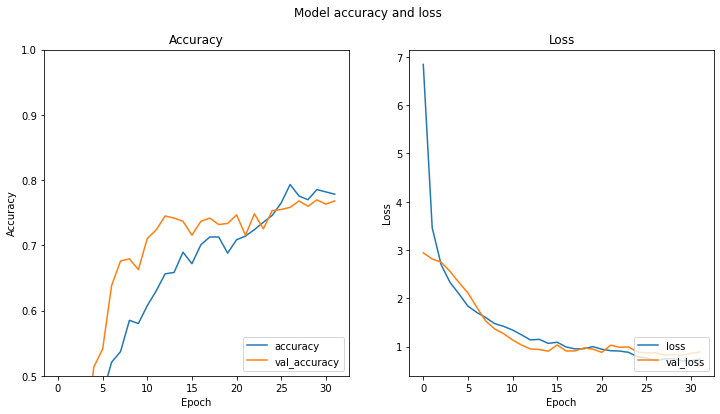



With tanh activation:
19/19 - 0s - loss: 0.7969 - accuracy: 0.7747 - 164ms/epoch - 9ms/step
Test accuracy: 77.467%

19/19 - 0s - loss: 0.8903 - accuracy: 0.7549 - 155ms/epoch - 8ms/step


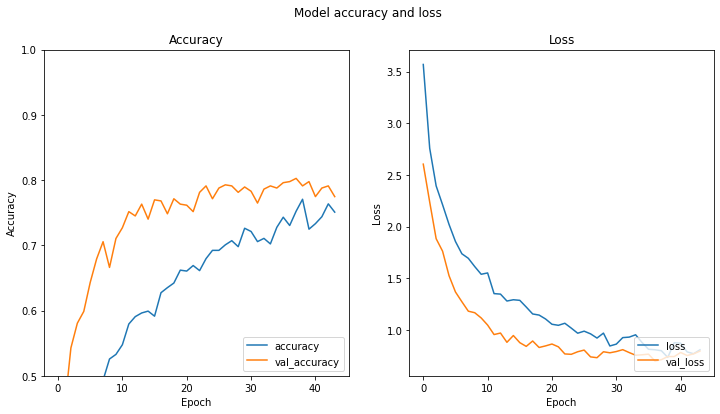



With sigmoid activation:
19/19 - 0s - loss: 3.2190 - accuracy: 0.0395 - 160ms/epoch - 8ms/step
Test accuracy: 3.947%

19/19 - 0s - loss: 0.7969 - accuracy: 0.7747 - 180ms/epoch - 9ms/step


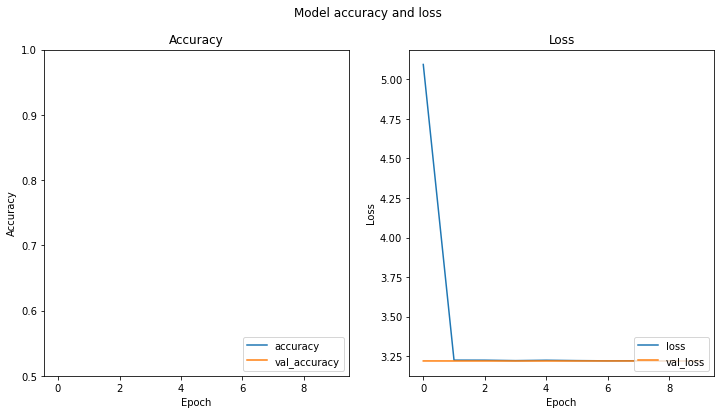



With leaky ReLU activation:
19/19 - 0s - loss: 0.7866 - accuracy: 0.8092 - 163ms/epoch - 9ms/step
Test accuracy: 80.921%

19/19 - 0s - loss: 0.7969 - accuracy: 0.7747 - 180ms/epoch - 9ms/step


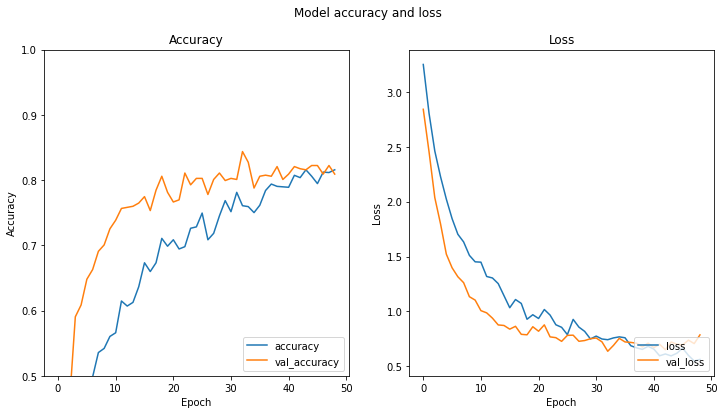

In [35]:
print("With ReLU activation:")
print_update_test_acc(model, best_model)
plot_model_accuracy(history)
print("\n")

par = {**best_model_params, **{"activation": "tanh"}}
model_tanh, history_tanh, params_tanh = create_and_solve_model(**par)
print("With tanh activation:")
res = print_update_test_acc(model_tanh, best_model)
if res:
    best_model = model_tanh
    best_model_params = params_tanh
plot_model_accuracy(history_tanh)
print("\n")

par = {**best_model_params, **{"activation": "sigmoid"}}
model_sigmoid, history_sigmoid, params_sigmoid = create_and_solve_model(**par)
print("With sigmoid activation:")
res = print_update_test_acc(model_sigmoid, best_model)
if res:
    best_model = model_sigmoid
    best_model_params = params_sigmoid
plot_model_accuracy(history_sigmoid)
print("\n")

par = {**best_model_params, **{"activation": "leaky_relu"}}
model_leaky, history_leaky, params_relu = create_and_solve_model(**par)
print("With leaky ReLU activation:")
res = print_update_test_acc(model_leaky, best_model)
if res:
    best_model = model_leaky
    best_model_params = params_relu
plot_model_accuracy(history_leaky)
print("\n")

<center><h3>Task 8.</h3></center>

With MaxPool2D:
19/19 - 0s - loss: 0.8902 - accuracy: 0.7681 - 192ms/epoch - 10ms/step
Test accuracy: 76.809%



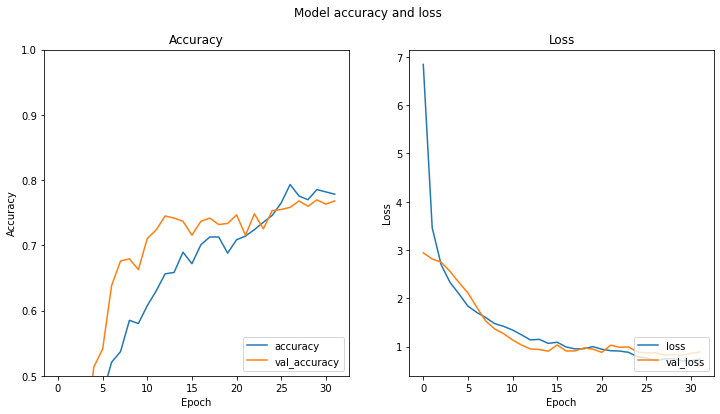



With AveragePooling2D:
19/19 - 0s - loss: 0.9042 - accuracy: 0.7615 - 187ms/epoch - 10ms/step
Test accuracy: 76.151%

19/19 - 0s - loss: 0.7866 - accuracy: 0.8092 - 185ms/epoch - 10ms/step


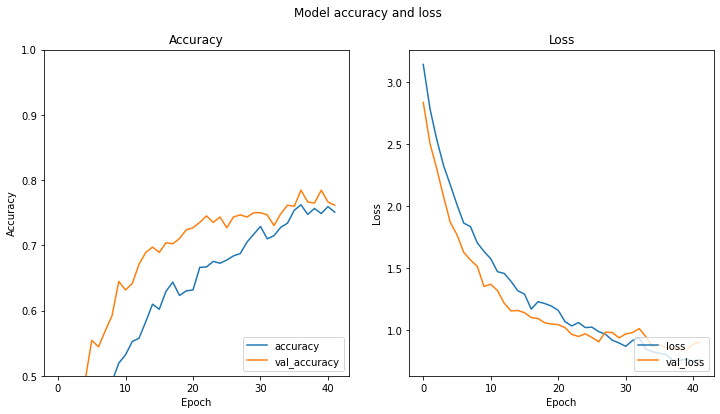

In [37]:
# Code
print("With MaxPool2D:")
print_update_test_acc(model)
plot_model_accuracy(history)
print("\n")

par = {**best_model_params, **{"pooling": layers.AveragePooling2D}}
model_AveragePooling2D, history_AveragePooling2D, params_AveragePooling2D = create_and_solve_model(**par)
print("With AveragePooling2D:")
res = print_update_test_acc(model_AveragePooling2D, best_model)
if res:
    best_model = model_AveragePooling2D
    best_model_params = params_AveragePooling2D
plot_model_accuracy(history_AveragePooling2D)
print("\n")

<center><h3>Task 9.</h3></center>

With 2 convolutional layers:
19/19 - 0s - loss: 0.6512 - accuracy: 0.8257 - 222ms/epoch - 12ms/step
Test accuracy: 82.566%

19/19 - 0s - loss: 0.7866 - accuracy: 0.8092 - 194ms/epoch - 10ms/step


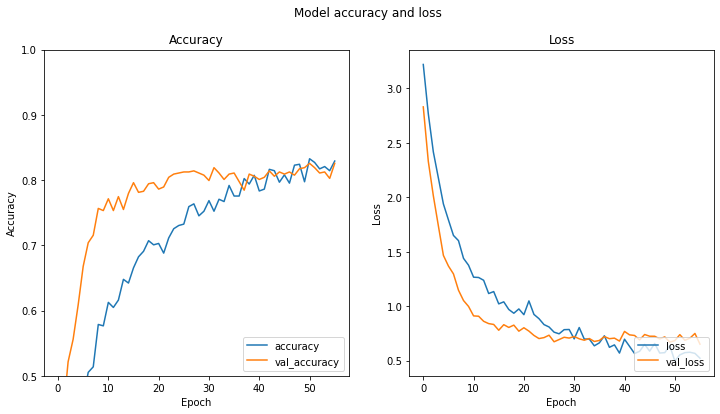



With 3 convolutional layers:
19/19 - 0s - loss: 0.6137 - accuracy: 0.8207 - 217ms/epoch - 11ms/step
Test accuracy: 82.072%

19/19 - 0s - loss: 0.6512 - accuracy: 0.8257 - 238ms/epoch - 13ms/step


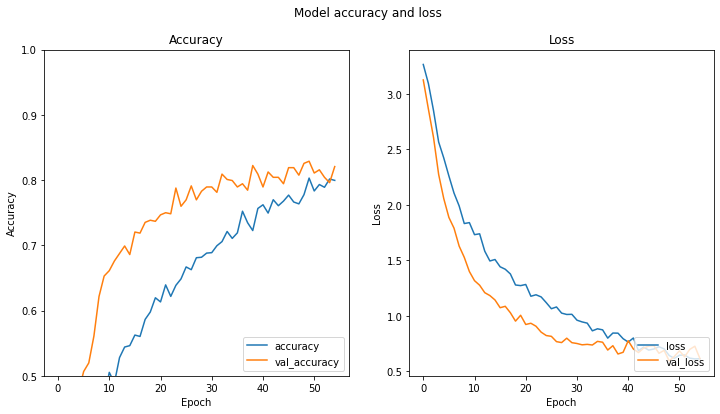



With 4 convolutional layers:
19/19 - 0s - loss: 1.0769 - accuracy: 0.7500 - 206ms/epoch - 11ms/step
Test accuracy: 75.0%

19/19 - 0s - loss: 0.6137 - accuracy: 0.8207 - 205ms/epoch - 11ms/step


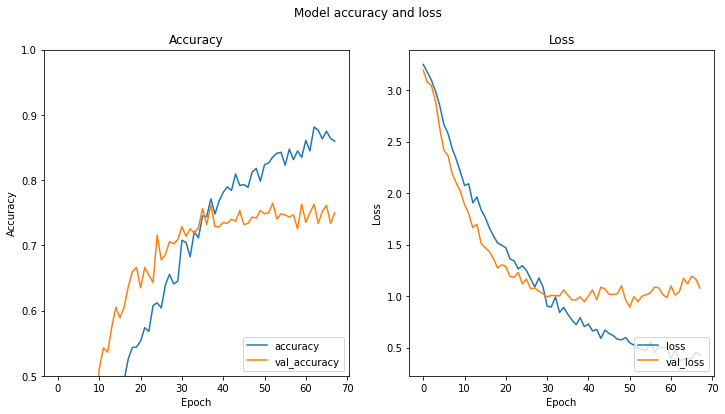

In [38]:
for no_layers in range(2, 5):
    par = {**best_model_params, **{"no_conv_layers": no_layers}}
    model_n, history_n, params_n = create_and_solve_model(**par)
    
    print(f"With {no_layers} convolutional layers:")
    res = print_update_test_acc(model_n, best_model)
    if res:
        best_model = model_n
        best_model_params = params_n
    plot_model_accuracy(history_n)
    print("\n")

<center><h3>Task 11.</h3></center>

With batch size 1:
19/19 - 0s - loss: 1.9975 - accuracy: 0.4194 - 273ms/epoch - 14ms/step
Test accuracy: 41.941%

19/19 - 0s - loss: 0.6137 - accuracy: 0.8207 - 184ms/epoch - 10ms/step


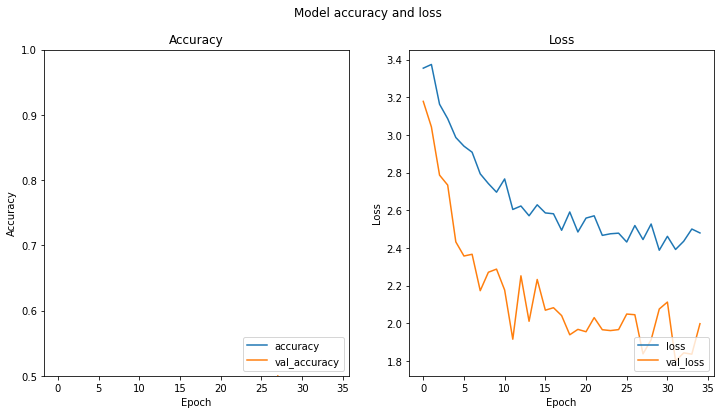



With batch size 8:
19/19 - 0s - loss: 0.8341 - accuracy: 0.7763 - 274ms/epoch - 14ms/step
Test accuracy: 77.632%

19/19 - 0s - loss: 0.6137 - accuracy: 0.8207 - 184ms/epoch - 10ms/step


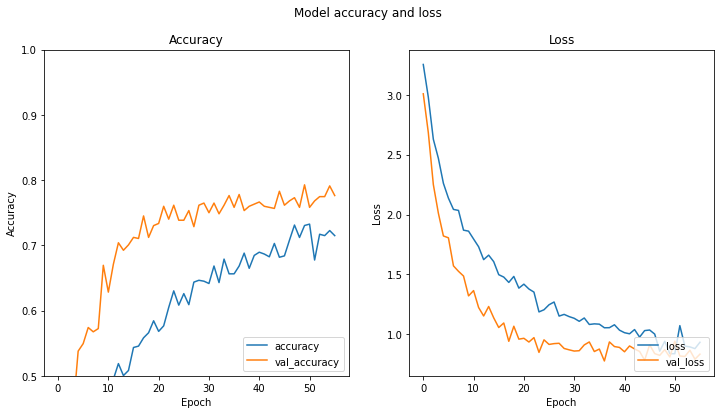



With batch size 64:
19/19 - 0s - loss: 0.7435 - accuracy: 0.8125 - 270ms/epoch - 14ms/step
Test accuracy: 81.25%

19/19 - 0s - loss: 0.6137 - accuracy: 0.8207 - 194ms/epoch - 10ms/step


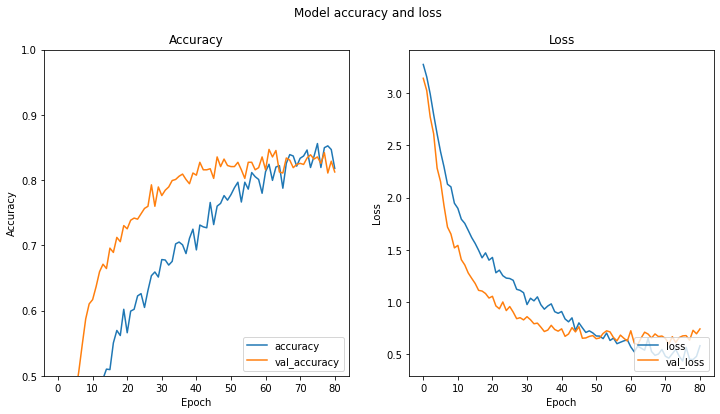



With batch size 128:
19/19 - 0s - loss: 0.8313 - accuracy: 0.7714 - 285ms/epoch - 15ms/step
Test accuracy: 77.138%

19/19 - 0s - loss: 0.7435 - accuracy: 0.8125 - 207ms/epoch - 11ms/step


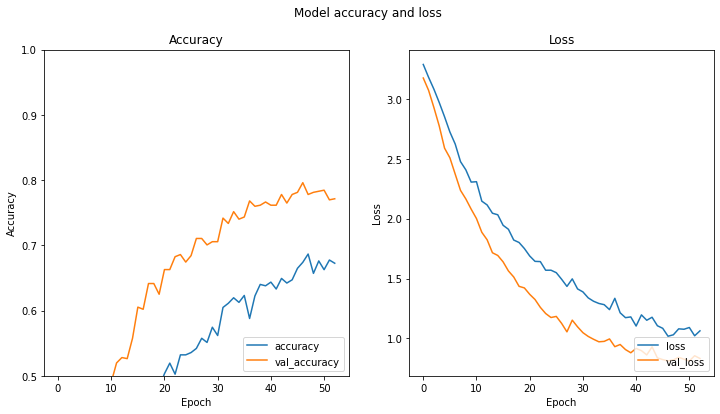

In [39]:
for batch_size in [1, 8, 64, 128]:
    par = {**best_model_params, **{"batch_size": batch_size}}
    model_batch, history_batch, params_batch = create_and_solve_model(**par)
    
    print(f"With batch size {batch_size}:")
    res = print_update_test_acc(model_batch, best_model)
    if res:
        best_model = model_batch
        best_model_params = params_batch
    plot_model_accuracy(history_batch)
    print("\n")